In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import bs4 
import re
import seaborn as sns
%matplotlib inline

In [277]:
def get_draft_html(year, week):
    site = 'http://www.vegasinsider.com/nfl/scoreboard/scores.cfm/week/{week}/season/{year}'.format(week=week, year=year)
    page = urlopen(site)
    soup = bs4.BeautifulSoup(page, 'html.parser')
    return soup


In [278]:
def winner(vis, home):
    if home > vis:
        return 'home'
    elif home < vis:
        return 'visitor'
    else:
        return 'push'



def adjust_odds(visitor_odds, home_odds):
    if visitor_odds < 0:
        return visitor_odds
    else:
        return -home_odds
    

def CleanData(year, week):
    soup = get_draft_html(year, week)
    teams = [i.text for i in soup.find_all('a', {"class": "black"}) if len(i.text) < 4]
    teams = ["blank", "blank"] + teams
    teams = np.array(teams)
    teams.resize(int(len(teams)/2), 2)

    scores_1 = [float(i.text.strip()) for i in soup.find_all('td', {"class": "sportPicksBorderL2 zerocenter"}) if i.text.strip() != "Score"]
    scores_2 = [i.text.strip() for i in soup.find_all('td', {"class": "sportPicksBorderL zerocenter"})]

    string_split = ','.join(scores_2).split("Odds")
    new_list = ["Odds" + line for line in string_split][1:]


    col_1 = []
    col_2 = []
    for i in new_list:
        col_1.append(i.split('T')[0] + 'T')
        col_2.append(i.split('T')[1])


    col_1_flat = []
    for i in col_1:
        col_1_flat = col_1_flat + i.split(',')

    col_2_flat = []
    for i in col_2:
        if i[-1] == ',':
            col_2_flat = col_2_flat + i[1:-1].split(',')   
        else:
            col_2_flat = col_2_flat + i[1:].split(',')   


    teams_flat_away = []
    teams_flat_home = []
    switch = 0
    count = 0
    for i in range(len(col_1_flat)):
        if col_1_flat[i] == 'Odds':
            count = count + 1

        teams_flat_away.append(teams[count][0])
        teams_flat_home.append(teams[count][1])





    df = pd.DataFrame({'team_away': teams_flat_away
                       ,'team_home': teams_flat_home
                       ,'reference': col_1_flat
                       , 'score_away': scores_1
                       , 'score_home': col_2_flat

                      }) 
    PKToZero = lambda x: 0 if x == 'PK' else x
    df['score_away'] = df.score_away.apply(PKToZero)
    df['score_home'] = df.score_home.apply(PKToZero)
    
    df_T = df[df['reference'].isin(['T'])].drop(columns=['reference']).reset_index(drop=True)
    df_odds = df[df['reference'].isin(['Odds'])].rename(columns={'score_away': 'odds_away', 'score_home': 'odds_home'}).drop(columns=['team_away', 'team_home', 'reference']).reset_index(drop=True)

    df_final = df_T.merge(df_odds, left_index=True, right_index=True)
    return df_final

def AlterDF(df_final):
    df_final[['score_away', 'score_home', 'odds_away', 'odds_home']] = df_final[['score_away', 'score_home', 'odds_away', 'odds_home']].astype('float')        
    
    df_final['adj_odds_away'] = df_final[['odds_away', 'odds_home']].apply(lambda x: adjust_odds(x['odds_away'].astype('int'), x['odds_home'].astype('float')), axis=1)
    df_final['adj_score_away'] = df_final.score_away + df_final.adj_odds_away

    df_final['winner'] = df_final[['score_away', 'score_home']].apply(lambda x: winner(x['score_away'].astype('int'), x['score_home'].astype('float')), axis=1)
    df_final['winner_ATS'] = df_final[['adj_score_away', 'score_home']].apply(lambda x: winner(x['adj_score_away'].astype('int'), x['score_home'].astype('float')), axis=1)
    
    df_final['week'] = week
    df_final['year'] = year
    return df_final

In [279]:
test = CleanData(2014, 12) #2013, 12
#2014, 12
#2012, 8
#2017, 1



ValueError: could not convert string to float: 

In [284]:
year_range = range(2017, 2018)
week_range = range(2, 18)
skip_list =[(2014, 12), (2017, 1)]
for year in year_range:
    for week in week_range:
        print(week, year)
        df = CleanData(year, week)
        df = AlterDF(df)
        df.to_csv('NFL_ATS.csv', header=False, index=False, mode='a')


        

2 2017
3 2017
4 2017
5 2017
6 2017
7 2017
8 2017
9 2017
10 2017
11 2017
12 2017
13 2017
14 2017
15 2017
16 2017
17 2017


In [26]:
df = pd.read_csv('NFL_ATS.csv')

In [35]:
df['score_difference'] = abs(df.score_away - df.score_home)

In [36]:
df

,team_away,team_home,score_away,score_home,odds_away,odds_home,adj_odds_away,adj_score_away,winner,winner_ATS,week,year,score_difference
0,NOR,GNB,34.0,42.0,47.5,-5.0,5.0,39.0,home,home,1,2011,8.0
1,PIT,BAL,7.0,35.0,37.0,-1.5,1.5,8.5,home,home,1,2011,28.0
2,DET,TAM,27.0,20.0,43.5,-1.5,1.5,28.5,visitor,visitor,1,2011,7.0
3,ATL,CHI,12.0,30.0,-2.0,40.5,-2.0,10.0,home,home,1,2011,18.0
4,BUF,KAN,41.0,7.0,39.5,-4.0,4.0,45.0,visitor,visitor,1,2011,34.0
5,IND,HOU,7.0,34.0,44.0,-9.0,9.0,16.0,home,home,1,2011,27.0
6,PHI,LAR,31.0,13.0,-3.5,44.0,-3.0,28.0,visitor,visitor,1,2011,18.0
7,CIN,CLE,27.0,17.0,36.5,-7.0,7.0,34.0,visitor,visitor,1,2011,10.0
8,TEN,JAC,14.0,16.0,-1.0,38.0,-1.0,13.0,home,home,1,2011,2.0
9,NYG,WAS,14.0,28.0,-1.5,41.0,-1.0,13.0,home,home,1,2011,14.0


In [6]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [7]:
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

In [53]:
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
import scipy.special

def make_plot(title, hist, edges, x):
    p = figure(title=title, tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
#     p.line(x, pdf, line_color="#ff8888", line_width=4, alpha=0.7, legend="PDF")
#     p.line(x, cdf, line_color="orange", line_width=2, alpha=0.7, legend="CDF")

    p.y_range.start = 0
    p.legend.location = "center_right"
    p.legend.background_fill_color = "#fefefe"
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color="white"
    return p

In [64]:
hist, edges = np.histogram(df[df['year'] == 2011].score_difference, density=True, bins=10)

In [65]:
x = np.linspace(-2, 2, 256)


In [66]:
p1 = make_plot("NFL Score Difference", hist, edges, x)

In [67]:
show(p1)

In [ ]:
group = df.groupby(by=['cyl', 'mfr'])
source = ColumnDataSource(group)

p = figure(plot_width=800, plot_height=300, title="NFL Score Difference",
           x_range=group, toolbar_location=None, tools="")

p.xgrid.grid_line_color = None
p.xaxis.axis_label = "Manufacturer grouped by # Cylinders"
p.xaxis.major_label_orientation = 1.2

index_cmap = factor_cmap('cyl_mfr', palette=['#2b83ba', '#abdda4', '#ffffbf', '#fdae61', '#d7191c'], 
                         factors=sorted(df.cyl.unique()), end=1)

p.vbar(x='cyl_mfr', top='mpg_mean', width=1, source=source,
       line_color="white", fill_color=index_cmap, 
       hover_line_color="darkgrey", hover_fill_color=index_cmap)

p.add_tools(HoverTool(tooltips=[("MPG", "@mpg_mean"), ("Cyl, Mfr", "@cyl_mfr")]))

show(p)

In [29]:
df['team_away'] = df.team_away.apply(FindandReplaceTeamsNames)
df['team_home'] = df.team_home.apply(FindandReplaceTeamsNames)

In [31]:
teams = df.team_away.drop_duplicates()

In [ ]:
p = figure(plot_width=800, plot_height=300, title="NFL Score Difference",
           x_range=group, toolbar_location=None, tools="")

In [10]:
df.groupby('year').count()

,team_away,team_home,score_away,score_home,odds_away,odds_home,adj_odds_away,adj_score_away,winner,winner_ATS,week
year,,,,,,,,,,,
2011,256,256,256,256,256,256,256,256,256,256,256
2012,256,256,256,256,256,256,256,256,256,256,256
2013,256,256,256,256,256,256,256,256,256,256,256
2014,241,241,241,241,241,241,241,241,241,241,241
2015,256,256,256,256,256,256,256,256,256,256,256
2016,256,256,256,256,256,256,256,256,256,256,256
2017,241,241,241,241,241,241,241,241,241,241,241


In [11]:
def WinningTeam(row):
    if row['winner_ATS'] == 'home':
        return row['team_home']
    elif row['winner_ATS'] == 'visitor':
        return row['team_away']
    else:
        return 'push'
def LosingTeam(row):
    if row['winner_ATS'] == 'home':
        return row['team_away']
    elif row['winner_ATS'] == 'visitor':
        return row['team_home']
    else:
        return 'push'

In [12]:
df['winning_team'] = df[['team_away', 'team_home', 'winner_ATS']].apply(WinningTeam, axis=1)
df['losing_team'] = df[['team_away', 'team_home', 'winner_ATS']].apply(LosingTeam, axis=1)

In [13]:
df['year_week'] = (df.week/100) + df.year

In [14]:
teams_list = df['team_away'].drop_duplicates().tolist()
teams_list = [team for team in teams_list if team not in ('STL', 'LA', 'SDG')]

In [15]:
fixteams = {'SDG': 'LAC', 'LA': 'LAR', 'STL': 'LAR'}

def FindandReplaceTeamsNames(team):
    try:
        return fixteams[team]
    except:
        return team

In [16]:
df_teams = pd.DataFrame(columns=teams_list)

In [17]:
df2 = pd.concat([df[['year_week', 'winning_team', 'losing_team']], df_teams], axis=1)

In [18]:
df2['winning_team'] = df2.winning_team.apply(FindandReplaceTeamsNames)
df2['losing_team'] = df2.losing_team.apply(FindandReplaceTeamsNames)

In [19]:
df2

,year_week,winning_team,losing_team,NOR,PIT,DET,ATL,BUF,IND,PHI,...,TAM,CLE,HOU,SFO,MIA,DEN,NYJ,WAS,LAR,LAC
0,2011.01,GNB,NOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011.01,BAL,PIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011.01,DET,TAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011.01,CHI,ATL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011.01,BUF,KAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011.01,HOU,IND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2011.01,PHI,LAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2011.01,CIN,CLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2011.01,JAC,TEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2011.01,WAS,NYG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [400]:
def win(row, col_team):
    if row['winning_team'] == col_team:
        return 1
    else:
        return None
    
def lose(row, col_team):
    if row['losing_team'] == col_team:
        return 1
    else:
        return None

In [401]:
for col_team in teams_list:
    col_team_win = col_team + '_win'
    col_team_lose = col_team + '_lose'
    df2[col_team_win] = df2.apply(lambda x: win(x, col_team), axis=1)
    df2[col_team_lose] = df2.apply(lambda x: lose(x, col_team), axis=1)

In [434]:
df3 = df2.drop(['winning_team', 'losing_team'] + teams_list, axis=1).groupby('year_week').sum()

In [435]:
df3['year_week'] = df3.index

In [436]:
year_fun = lambda x: int(str(x).split('.')[0])
df3['year'] = df3.year_week.apply(year_fun)

In [442]:
team_win_lose_list = [col for col in list(df3) if col not in ('year_week', 'year')]

/Users/wcasey/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [501]:
df5 = pd.DataFrame(columns=df5_cols+['year_week'])

def TotalGames(row, team):
    return row[team +'_win'] + row[team +'_lose']
def WinPercent(row, team):
    return row[team +'_win']/row[team + '_total_games']

for year in range(2011, 2018):
    df4 = df3[df3['year'] == year]
    df4[team_win_lose_list] = df4[team_win_lose_list].cumsum()

    for team in teams_list:
        team_total_games = team+'_total_games'
        team_win_percent = team+'_win_percent'
        df4[team_total_games] = df4.apply(lambda x: TotalGames(x, team), axis=1)
        df4[team_win_percent] = df4.apply(lambda x: WinPercent(x, team), axis=1)

    df5_cols = [col for col in list(df4) if 'percent' in col.split("_")]
    df5 = pd.concat([df5, df4[df5_cols+['year_week']]])
    

/Users/wcasey/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/wcasey/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/wcasey/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [565]:
df5

,NOR_win_percent,PIT_win_percent,DET_win_percent,ATL_win_percent,BUF_win_percent,IND_win_percent,PHI_win_percent,CIN_win_percent,TEN_win_percent,NYG_win_percent,...,CLE_win_percent,HOU_win_percent,SFO_win_percent,MIA_win_percent,DEN_win_percent,NYJ_win_percent,WAS_win_percent,LAR_win_percent,LAC_win_percent,year_week
2011.01,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2011.01
2011.02,0.500000,0.500000,1.000000,0.500000,1.000000,0.000000,0.500000,1.000000,0.500000,0.500000,...,0.500000,1.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,2011.02
2011.03,0.666667,0.333333,1.000000,0.333333,1.000000,0.333333,0.333333,0.666667,0.333333,0.666667,...,0.666667,0.666667,1.000000,0.000000,0.333333,0.333333,0.666667,0.000000,0.000000,2011.03
2011.04,0.750000,0.250000,1.000000,0.250000,0.666667,0.500000,0.250000,0.750000,0.500000,0.750000,...,0.500000,0.750000,1.000000,0.000000,0.250000,0.250000,0.750000,0.000000,0.250000,2011.04
2011.05,0.600000,0.400000,1.000000,0.200000,0.750000,0.400000,0.200000,0.800000,0.400000,0.600000,...,0.500000,0.600000,1.000000,0.000000,0.200000,0.200000,0.750000,0.000000,0.400000,2011.05
2011.06,0.500000,0.333333,0.800000,0.333333,0.750000,0.333333,0.333333,0.833333,0.400000,0.600000,...,0.500000,0.500000,1.000000,0.000000,0.200000,0.333333,0.600000,0.000000,0.400000,2011.06
2011.07,0.571429,0.428571,0.666667,0.428571,0.750000,0.285714,0.333333,0.833333,0.333333,0.600000,...,0.500000,0.571429,1.000000,0.000000,0.333333,0.428571,0.500000,0.000000,0.333333,2011.07
2011.08,0.500000,0.500000,0.714286,0.428571,0.800000,0.250000,0.428571,0.857143,0.428571,0.500000,...,0.400000,0.571429,1.000000,0.142857,0.285714,0.428571,0.428571,0.142857,0.285714,2011.08
2011.09,0.555556,0.444444,0.714286,0.500000,0.666667,0.222222,0.375000,0.875000,0.375000,0.571429,...,0.333333,0.625000,1.000000,0.250000,0.375000,0.500000,0.375000,0.125000,0.250000,2011.09
2011.10,0.600000,0.500000,0.625000,0.444444,0.571429,0.200000,0.333333,0.777778,0.444444,0.500000,...,0.285714,0.666667,1.000000,0.333333,0.444444,0.444444,0.333333,0.222222,0.222222,2011.10


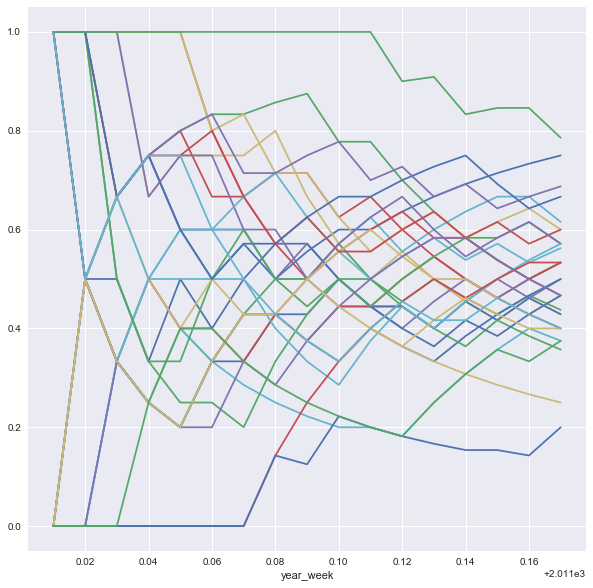

In [491]:
df5.plot(kind='line', figsize=(10, 10), legend=False)

In [558]:
def GetHomeWinPercent(row):
    if row['week'] == 1:
        return 0
    else:
        try:
            return df5.loc[row['year_week'] - .01, row['team_home']+'_win_percent']
        except:
            try:
                return df5.loc[ row['year_week'] - .02, row['team_home']+'_win_percent']
            except:
                return None
            
            
def GetAwayWinPercent(row):
    if row['week'] == 1:
        return 0
    else:
        try:
            return df5.loc[row['year_week'] - .01, row['team_away']+'_win_percent']
        except:
            try:
                return df5.loc[ row['year_week'] - .02, row['team_away']+'_win_percent']
            except:
                return None

In [559]:
df['home_win_percent'] = df[['week', 'year_week', 'team_home']].apply(GetHomeWinPercent, axis=1)
df['away_win_percent'] = df[['week', 'year_week', 'team_away']].apply(GetAwayWinPercent, axis=1)

In [663]:
df['home_win_binary'] = df['winner_ATS'].apply(lambda x: 1 if x == 'home' else 0)

In [664]:
df_for_model = df[df['winner_ATS'] != 'push'][['home_win_binary', 'home_win_percent', 'away_win_percent', 'week']]

In [665]:
df_for_model = df_for_model.dropna()

In [666]:
df_for_model = df_for_model[df_for_model['week'] > 16]

In [667]:
df_for_model['win_percent_diff'] = abs(df.home_win_percent - df.away_win_percent)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x118b7fc18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1190acc50>], dtype=object)

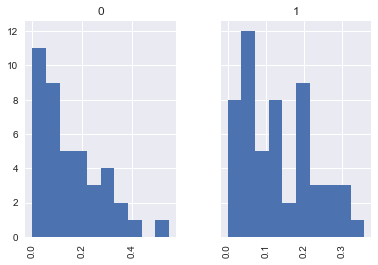

In [668]:
df_for_model.sort_values('win_percent_diff', ascending=False)[['win_percent_diff', 'home_win_binary']].hist(by='home_win_binary', column='win_percent_diff', sharey=True)

In [633]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [634]:
X = df_for_model[['home_win_percent', 'away_win_percent']]
y = df_for_model['home_win_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [635]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

In [636]:
clf.score(X_test, y_test)

0.48749999999999999

In [637]:
clf.predict_proba(X_test)

array([[ 0.46726834,  0.53273166],
       [ 0.52891831,  0.47108169],
       [ 0.51201437,  0.48798563],
       [ 0.47816271,  0.52183729],
       [ 0.48452612,  0.51547388],
       [ 0.50655428,  0.49344572],
       [ 0.46563546,  0.53436454],
       [ 0.50776781,  0.49223219],
       [ 0.51378752,  0.48621248],
       [ 0.47694589,  0.52305411],
       [ 0.47666125,  0.52333875],
       [ 0.53085854,  0.46914146],
       [ 0.49726594,  0.50273406],
       [ 0.51622549,  0.48377451],
       [ 0.51787991,  0.48212009],
       [ 0.49207435,  0.50792565],
       [ 0.52803611,  0.47196389],
       [ 0.50655428,  0.49344572],
       [ 0.51965339,  0.48034661],
       [ 0.52474119,  0.47525881],
       [ 0.46318946,  0.53681054],
       [ 0.48543014,  0.51456986],
       [ 0.50190752,  0.49809248],
       [ 0.51955907,  0.48044093],
       [ 0.46957633,  0.53042367],
       [ 0.45397019,  0.54602981],
       [ 0.48770984,  0.51229016],
       [ 0.50480138,  0.49519862],
       [ 0.5151392 ,